In [4]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from helpers import util
import json

import warnings
warnings.filterwarnings("ignore")

In [6]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
# This line will fail if you have not registered the AQICN_API_KEY as a secret in Hopsworks
AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value
sensors_str = secrets.get_secret("SENSORS_JSON").value
sensors_data = json.loads(sensors_str)

2025-11-12 00:39:00,209 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-12 00:39:00,213 INFO: Initializing external client
2025-11-12 00:39:00,213 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-12 00:39:01,778 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272018


In [7]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [8]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-12 00:39:15,263 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] as features for the query.To include primary key and event time use `select_all`.


In [9]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272018/fs/1265761/fv/air_quality_fv/version/1


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [10]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [11]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


In [12]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2021-09-10 00:00:00+00:00,15.556998,0.1,11.966954,114.607750
1,2021-09-11 00:00:00+00:00,15.348666,7.4,8.699793,179.999985
2,2021-09-12 00:00:00+00:00,14.613251,8.9,15.137133,271.777954
3,2021-09-13 00:00:00+00:00,11.788250,0.0,13.708391,325.136597
4,2021-09-14 00:00:00+00:00,12.613250,0.0,8.788720,149.534531
...,...,...,...,...,...
5906,2025-04-26 00:00:00+00:00,6.244501,0.0,10.436895,313.794006
5907,2025-04-27 00:00:00+00:00,9.006999,0.0,26.377216,224.784073
5908,2025-04-28 00:00:00+00:00,10.779916,0.5,32.442471,242.646667
5909,2025-04-29 00:00:00+00:00,12.359082,0.0,19.060459,294.809357


In [13]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [14]:
y_train

,pm25
0,10.60
1,10.02
2,4.47
3,0.52
4,0.60
...,...
5906,0.50
5907,1.40
5908,2.77
5909,0.37


---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [15]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 4.825536
R squared: -0.14282355702534577


In [17]:
df = y_test
df['predicted_pm25'] = y_pred

In [18]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
1215,1.60,3.402149,2025-05-01 00:00:00+00:00
3010,2.60,3.402149,2025-05-01 00:00:00+00:00
5911,2.00,3.402149,2025-05-01 00:00:00+00:00
3804,3.49,3.402149,2025-05-01 00:00:00+00:00
5912,0.30,0.049296,2025-05-02 00:00:00+00:00


In [35]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

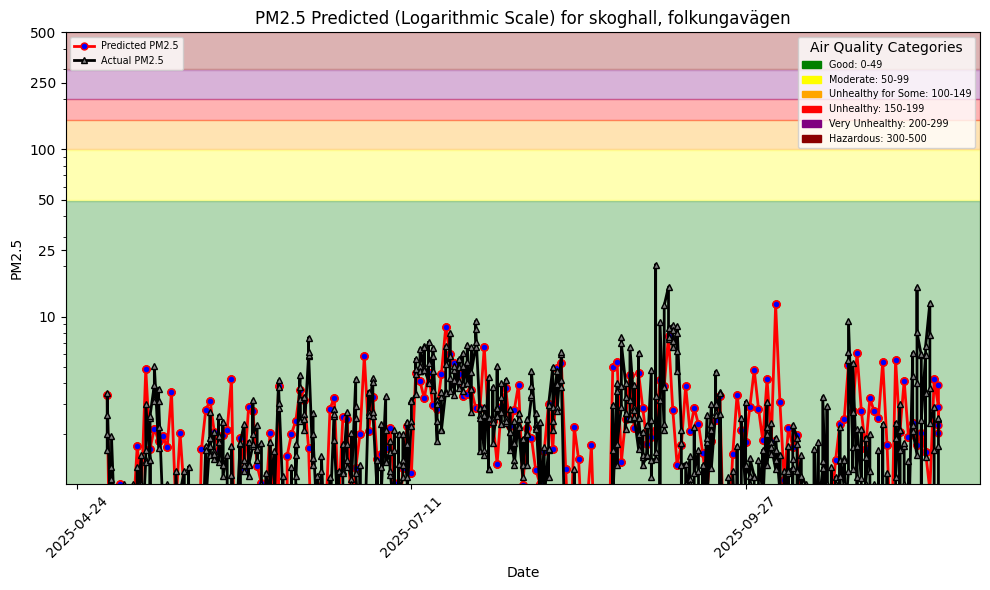

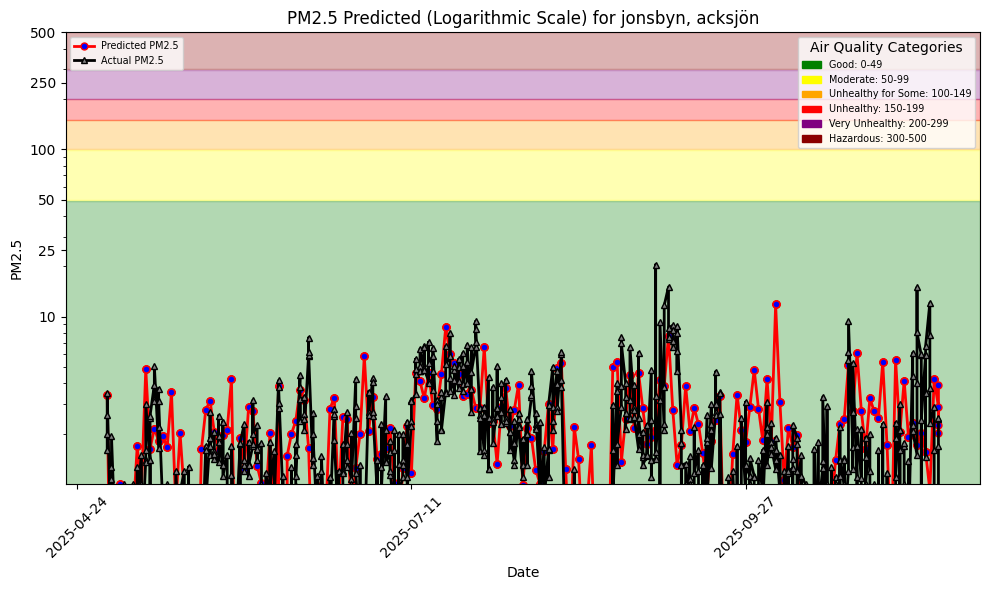

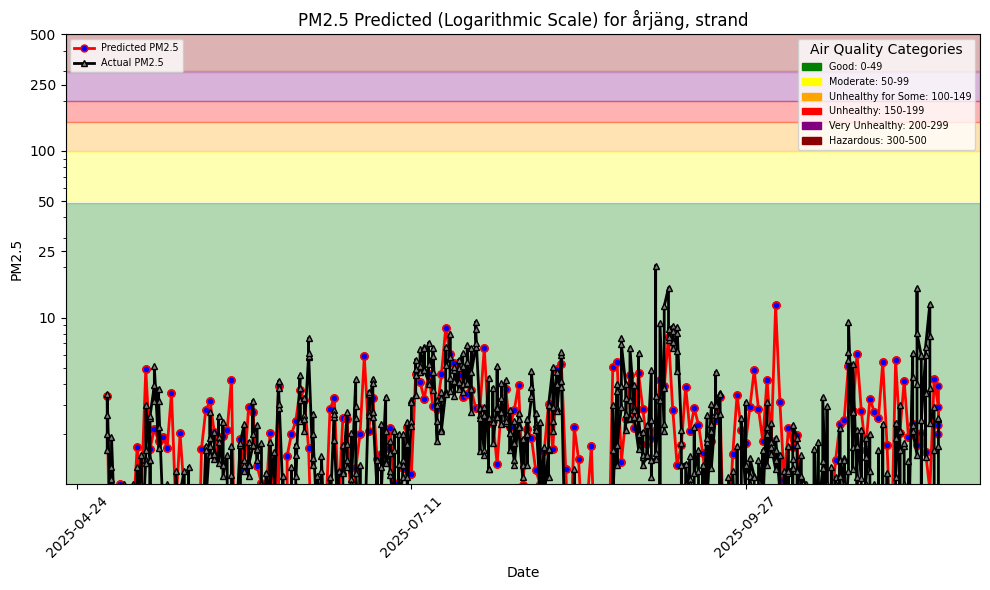

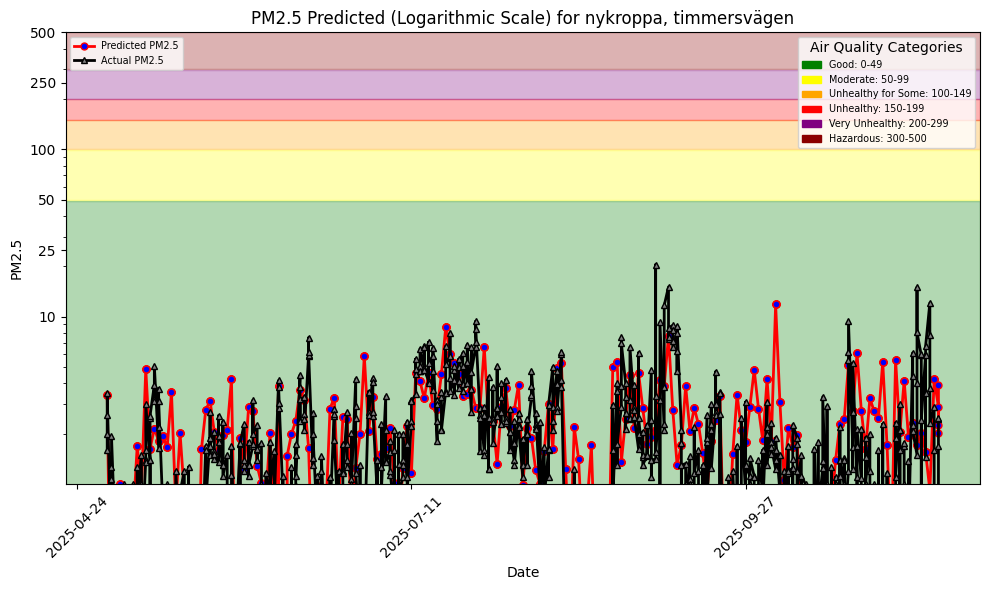

In [37]:
for location in sensors_data:
    city = location['city']
    street = location['street']
    city_dir = f"{images_dir}/{city}"
    if not os.path.exists(city_dir):
        os.mkdir(city_dir)
    file_path = f"{city_dir}/pm25_hindcast.png"
    plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
    plt.show()

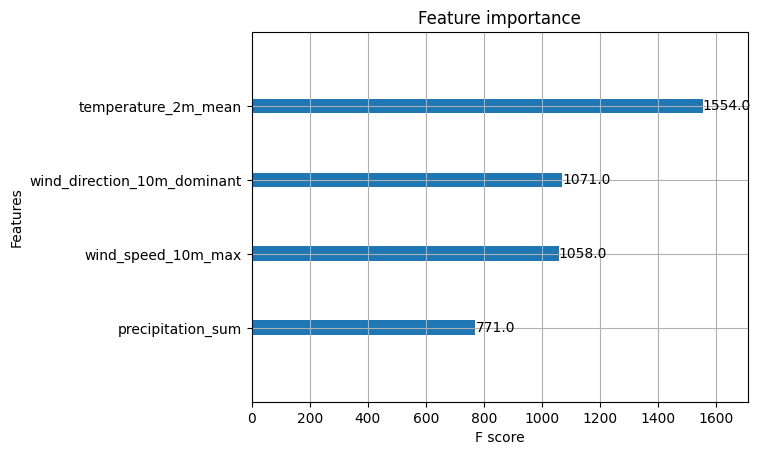

In [24]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [25]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [26]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [27]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/519172 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19517 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/121660 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/121855 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/119369 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/120746 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272018/models/air_quality_xgboost_model/1


Model(name: 'air_quality_xgboost_model', version: 1)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
